In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# import libraries
from datetime import datetime, timedelta
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from __future__ import division

import plotly.graph_objects as go

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
customer = pd.read_csv('../content/drive/My Drive/sales_data/customers_dataset.csv', engine='python')
orders_df = pd.read_csv('../content/drive/My Drive/sales_data2/olist_orders_dataset.csv', engine='python')
order_items = pd.read_csv('../content/drive/My Drive/sales_data2/olist_order_items_dataset.csv', engine='python')

In [ ]:
orders = pd.merge(customer, orders_df, how ='left', on='customer_id')

In [ ]:
orders = pd.merge(orders, order_items,how ='left', on='order_id')

In [ ]:
col = ['customer_unique_id', 'price', 'order_item_id', 'order_purchase_timestamp']
orders = orders[col]

In [ ]:
#converting the type of Invoice Date Field from string to datetime.
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

# Recency

In [ ]:
#create a generic user dataframe to keep CustomerID and new segmentation scores
orders_user = pd.DataFrame(orders['customer_unique_id'].unique())
orders_user.columns = ['customer_unique_id']

#get the max purchase date for each customer and create a dataframe with it
orders_max_purchase = orders.groupby('customer_unique_id').order_purchase_timestamp.max().reset_index()
orders_max_purchase.columns = ['customer_unique_id','MaxPurchaseDate']

#we take our observation point as the max invoice date in our dataset
orders_max_purchase['Recency'] = (orders_max_purchase['MaxPurchaseDate'].max() - orders_max_purchase['MaxPurchaseDate']).dt.days

#merge this dataframe to our new user dataframe
orders_user = pd.merge(orders_user, orders_max_purchase[['customer_unique_id','Recency']], on='customer_unique_id')

orders_user.head()

customer_unique_id  Recency
0  861eff4711a542e4b93843c6dd7febb0      519
1  290c77bc529b7ac935b93aa66c333dc3      277
2  060e732b5b29e8181a18229c7b0b2b5e      151
3  259dac757896d24d7702b9acbbff3f3c      218
4  345ecd01c38d18a9036ed96c73b8d066       80

In [ ]:
#plot a recency histogram

plot_data = [
    go.Histogram(
        x=orders_user['Recency']
    )
]

plot_layout = go.Layout(
        title='Recency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

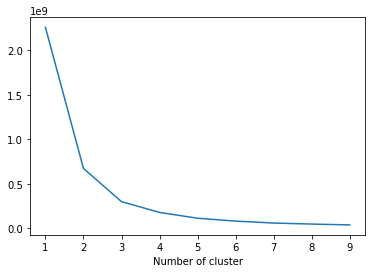

In [ ]:
from sklearn.cluster import KMeans

sse={}
orders_recency = orders_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(orders_recency)
    orders_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [ ]:
#build 4 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=4)
kmeans.fit(orders_user[['Recency']])
orders_user['RecencyCluster'] = kmeans.predict(orders_user[['Recency']])

#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

orders_user = order_cluster('RecencyCluster', 'Recency',orders_user,False)

In [ ]:
orders_user.groupby('RecencyCluster')['Recency'].describe()

count        mean        std  ...    50%    75%    max
RecencyCluster                                  ...                     
0               17324.0  533.291792  59.832968  ...  524.0  576.0  772.0
1               25064.0  362.701923  43.263521  ...  356.0  399.0  447.0
2               27769.0  232.372754  35.122056  ...  232.0  263.0  297.0
3               25939.0  110.566406  36.071041  ...  110.0  144.0  171.0

[4 rows x 8 columns]

# Frequency

In [ ]:
#get order counts for each user and create a dataframe with it
orders_frequency = orders.groupby('customer_unique_id').order_purchase_timestamp.count().reset_index()
orders_frequency.columns = ['customer_unique_id','Frequency']

#add this data to our main dataframe
orders_user = pd.merge(orders_user, orders_frequency, on='customer_unique_id')

In [ ]:
#plot the histogram
plot_data = [
    go.Histogram(
        x=orders_user.query('Frequency < 1000')['Frequency']
    )
]

plot_layout = go.Layout(
        title='Frequency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

In [ ]:
#k-means
kmeans = KMeans(n_clusters=4)
kmeans.fit(orders_user[['Frequency']])
orders_user['FrequencyCluster'] = kmeans.predict(orders_user[['Frequency']])

#order the frequency cluster
orders_user = order_cluster('FrequencyCluster', 'Frequency',orders_user,True)

#see details of each cluster
orders_user.groupby('FrequencyCluster')['Frequency'].describe()

count       mean       std  min   25%   50%   75%   max
FrequencyCluster                                                           
0                 84151.0   1.000000  0.000000  1.0   1.0   1.0   1.0   1.0
1                 10742.0   2.157047  0.363862  2.0   2.0   2.0   2.0   3.0
2                  1148.0   4.744774  0.972247  4.0   4.0   4.0   5.0   8.0
3                    55.0  11.927273  3.332525  9.0  10.0  11.0  12.0  24.0

# Revenue

In [ ]:
#calculate revenue for each customer
orders['Revenue'] = orders['price'] * orders['order_item_id']
orders_revenue = orders.groupby('customer_unique_id').Revenue.sum().reset_index()

#merge it with our main dataframe
orders_user = pd.merge(orders_user, orders_revenue, on='customer_unique_id')

#plot the histogram
plot_data = [
    go.Histogram(
        x=orders_user.query('Revenue < 10000')['Revenue']
    )
]

plot_layout = go.Layout(
        title='Monetary Value'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

In [ ]:
#apply clustering
kmeans = KMeans(n_clusters=4)
kmeans.fit(orders_user[['Revenue']])
orders_user['RevenueCluster'] = kmeans.predict(orders_user[['Revenue']])


#order the cluster numbers
orders_user = order_cluster('RevenueCluster', 'Revenue',orders_user,True)

#show details of the dataframe
orders_user.groupby('RevenueCluster')['Revenue'].describe()

count          mean  ...       75%      max
RevenueCluster                         ...                   
0               91591.0    114.383282  ...    149.90    535.9
1                4380.0    958.844678  ...   1106.99   3124.0
2                 124.0   5330.965565  ...   5850.00  21000.0
3                   1.0  60480.000000  ...  60480.00  60480.0

[4 rows x 8 columns]

# Overall Score

In [ ]:
#calculate overall score and use mean() to see details
orders_user['OverallScore'] = orders_user['RecencyCluster'] + orders_user['FrequencyCluster'] + orders_user['RevenueCluster']
orders_user.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



Recency  Frequency      Revenue
OverallScore                                    
0             532.960070   1.000000   102.031549
1             378.206171   1.075928   127.369977
2             251.421429   1.128567   141.494018
3             132.791356   1.171811   151.887764
4             136.360532   2.138589   459.170201
5             149.474886   3.646880   962.015967
6             142.864734   5.521739  2149.913623
7             149.000000   9.204545  4734.113636
8              91.333333  14.333333  7554.533333

In [ ]:
orders_user['Segment'] = 'Low-Value'
orders_user.loc[orders_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
orders_user.loc[orders_user['OverallScore']>4,'Segment'] = 'High-Value' 

In [ ]:
#Revenue vs Frequency
orders_graph = orders_user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=orders_graph.query("Segment == 'Low-Value'")['Frequency'],
        y=orders_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=orders_graph.query("Segment == 'Mid-Value'")['Frequency'],
        y=orders_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=orders_graph.query("Segment == 'High-Value'")['Frequency'],
        y=orders_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Frequency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

In [ ]:
#Revenue Recency

orders_graph = orders_user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=orders_graph.query("Segment == 'Low-Value'")['Recency'],
        y=orders_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=orders_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=orders_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=orders_graph.query("Segment == 'High-Value'")['Recency'],
        y=orders_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

In [ ]:
# Revenue vs Frequency
orders_graph = orders_user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=orders_graph.query("Segment == 'Low-Value'")['Recency'],
        y=orders_graph.query("Segment == 'Low-Value'")['Frequency'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=orders_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=orders_graph.query("Segment == 'Mid-Value'")['Frequency'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=orders_graph.query("Segment == 'High-Value'")['Recency'],
        y=orders_graph.query("Segment == 'High-Value'")['Frequency'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

In [ ]:
orders_user.head()

customer_unique_id  Recency  ...  OverallScore    Segment
0  861eff4711a542e4b93843c6dd7febb0      519  ...             0  Low-Value
1  7f3a72e8f988c6e735ba118d54f47458      524  ...             0  Low-Value
2  4390ddbb6276a66ff1736a6710205dca      551  ...             0  Low-Value
3  2e6a42a9b5cbb0da62988694f18ee295      519  ...             0  Low-Value
4  e021e698833bdeb89dfef3acb2e91f37      629  ...             0  Low-Value

[5 rows x 9 columns]